In [78]:
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn.model_selection as ms
from sklearn import metrics
import matplotlib.pyplot as plt
import os
from matplotlib.colors import LinearSegmentedColormap
from colour import Color
import shap
from matplotlib import rc

rc('text', usetex=True)


SEED = 42
N_THREADS = 25
os.environ['OMP_NUM_THREADS'] = str(N_THREADS)

colors = ['#3f7f93','#da3b46']
cmp_2 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))


In [65]:
dlist = ['dphibb', 'etaaa', 'ptb2', 'drbamin', 'met', 'etaa2', 'etab1', 'etaa1', 'nbjet', 'etab2', 'weight']
df_zh = pd.read_csv('../simulations/HL-LHC/zh.csv').drop(columns=dlist)
df_yb2 = pd.read_csv('../simulations/HL-LHC/yb2.csv').drop(columns=dlist)
df_zh['class'] = 0
df_yb2['class'] = 1

In [68]:
df_zh_train = df_zh.sample(n=20000)
df_yb2_train = df_yb2.sample(n=20000)

df_train = pd.concat([df_zh_train, df_yb2_train]).sample(frac=1)

In [71]:
X = df_train.drop(columns=['class'])
Y = df_train['class']

x_train, x_test, y_train, y_test = ms.train_test_split(X.values, Y.values, test_size=0.2, random_state=SEED)
eval_set = [(x_train, y_train), (x_test, y_test)]

classifier = xgb.XGBClassifier(max_depth=10, objective='multi:softprob', num_class=2, nthread=N_THREADS, n_estimators=5000, random_state=SEED)

classifier = classifier.fit(x_train, y_train, early_stopping_rounds=50, eval_set=eval_set,eval_metric=["merror", "mlogloss"], verbose=False)

y_pred = classifier.predict(x_test)
print("Accuracy Score: {:2.2f}%".format(100*metrics.accuracy_score(y_test, y_pred)))

Accuracy Score: 74.86%


In [92]:
X_shap = pd.DataFrame(x_test, columns=df_train.drop(columns=['class']).columns)
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_shap)

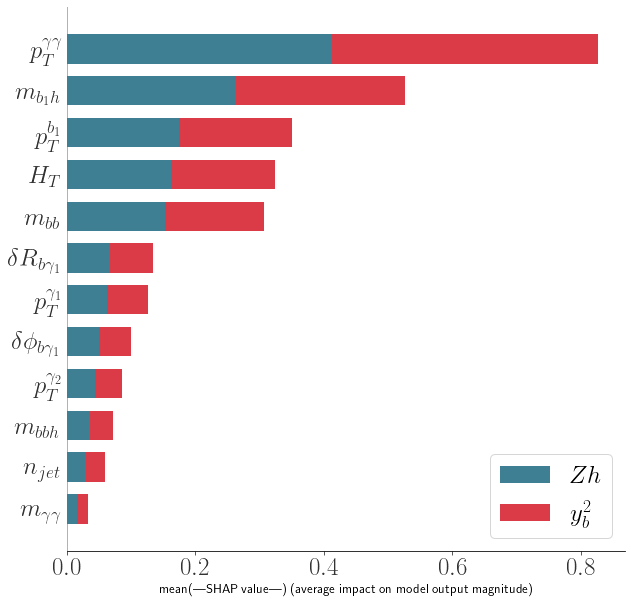

In [91]:
class_names = [r'$Zh$', r'$y_b^2$']
names = [r'$n_{jet}$', r'$p_T^{b_1}$', r'$p_T^{\gamma_1}$', r'$p_T^{\gamma_2}$', r'$p_T^{\gamma\gamma}$', r'$m_{bb}$', r'$m_{\gamma\gamma}$', r'$m_{b_1h}$', r'$m_{bbh}$',
           r'$H_T$', r'$\delta R_{b\gamma_1}$', r'$\delta\phi_{b\gamma_1}$']

shap.summary_plot(shap_values, X_shap, color=cmp_2, class_names=class_names, class_inds='original', plot_size=(10,10), show=False, feature_names=names)
plt.legend(fontsize=25)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=25)
plt.show()